## Single Image Classifier
Rather than training a classifier on multiple images from different locations, this trains the classifier on a single image for predicting inundation in clouds in the same image

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV

### Train classifier on sampled points from image

In [2]:
# If files are located on local computer, read tables directly

# CSV of sample points with features
points = pd.read_csv('../data/tables/sample_points_4337_LC08_026038_20160325.csv')
df = points.copy()
# df = df.replace(-999999, np.nan)
# df = df.dropna()
len(df)

30000

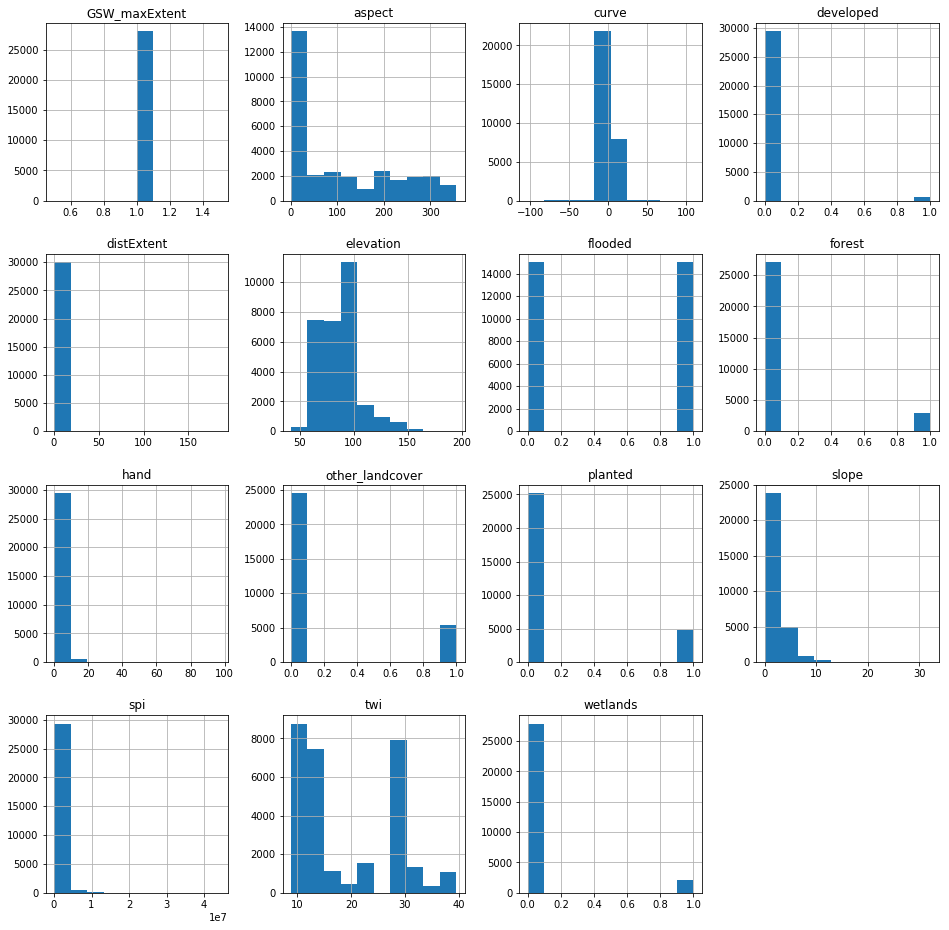

In [3]:
points.columns
hist = df.hist(figsize=(16, 16))
hist
plt.show()

In [4]:

df = df[df.distExtent < 10000000] # Some distExtent values are way too high - remove them

# dropCols = pd.concat([df.pop(x) for x in ['latitude','longitude']]) # Pop out imageID, lat, lon so we can check NaN and inf. 

# Check presence of infinite or NaN values
print(' Is NaN?:', np.any(np.isnan(df)), "\n",
     'Is inf?:', not np.any(np.isfinite(df)))

# Remove NaN
df = df.dropna()

# Rescale values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() # Using MinMax instead of standard scaler because not all features are normally distributed
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
# df_scaled = pd.concat([df_scaled, pd.DataFrame(imageID)]) # Add imageID back. Converting to NaN when I concat so leaving out for now

print(df_scaled)

# Separate features and target
Y = df['flooded'] # Target feature, drop from features
X = df.drop('flooded', axis=1) # Features

# Split data into training and testing sets (split once, use it )
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# Remove rows with NaN
X_train.dropna()
X_test.dropna()
y_train.dropna()
y_test.dropna()

print('Training data and target sizes: \n{}, {}'.format(X_train.shape,y_train.shape))
print('Test data and target sizes: \n{}, {}'.format(X_test.shape,y_test.shape))

 Is NaN?: True 
 Is inf?: False
       GSW_maxExtent    aspect     curve  developed  distExtent  elevation  \
0                0.0  0.645034  0.504717        0.0         0.0   0.211921   
1                0.0  0.419633  0.457547        0.0         0.0   0.317881   
2                0.0  0.161772  0.504717        0.0         0.0   0.317881   
3                0.0  0.925215  0.476415        0.0         0.0   0.291391   
4                0.0  0.925202  0.495283        0.0         0.0   0.291391   
5                0.0  0.169724  0.443396        0.0         0.0   0.185430   
6                0.0  0.644902  0.490566        0.0         0.0   0.178808   
7                0.0  0.822957  0.462264        0.0         0.0   0.211921   
8                0.0  0.252770  0.490566        0.0         0.0   0.132450   
9                0.0  0.139036  0.466981        0.0         0.0   0.105960   
10               0.0  0.505540  0.504717        0.0         0.0   0.271523   
11               0.0  0.317443  

In [5]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import time
def timer(start,end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
start_time = time.time()

# Grid of values for tuning hyperparameters
# C is the 

grid = [{'C': [0.0001, 0.001, 0.01, 0.1, 1.0],
         'tol': [0.0001, 0.001, 0.01, 0.1, 1.0]}]

model = LinearSVC()

gridcv = GridSearchCV(estimator=model, param_grid=grid, return_train_score=True)
gridcv.fit(X_train, y_train)
print('Support Vector Machine Best Score: ' + str(gridcv.best_score_))
print('Best C: ' + str(gridcv.best_estimator_.C))
print('Best tol: ' + str(gridcv.best_estimator_.tol))
print('Grid search runtime: ' + str(timer(start_time, time.time())))

Support Vector Machine Best Score: 0.8781693509807048
Best C: 0.1
Best tol: 1.0
00:02:52.13
Grid search runtime: None


In [6]:
# Benchmark training time
start_time = time.time()

clf = LinearSVC(C = gridcv.best_estimator_.C, 
                 tol=gridcv.best_estimator_.tol,
                 random_state=0)
clf.fit(X_train, y_train)

print('SVM training runtime: ' + str(timer(start_time, time.time())))

00:00:03.07
SVM training runtime: None


In [7]:
# Performance metrics
from sklearn import metrics
y_pred = clf.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(y_test, y_pred)/len(y_pred)*100, labels=['flooded','notFlooded'])

# Top row = predicted, left col = true

import math
def compute_rmse(predictions, yvalues):
    rmse = math.sqrt((sum((predictions - yvalues)**2))/len(yvalues))
    return rmse

# RMSE of test data
print('Test RMSE:', compute_rmse(y_pred, y_test))

# RMSE of train data
y_pred_train = clf.predict(X_train)
print('Train RMSE:', compute_rmse(y_pred_train, y_train))


Classification report for classifier LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

          0       0.85      0.81      0.83      4391
          1       0.84      0.87      0.85      4876

avg / total       0.84      0.84      0.84      9267


                  flooded notFlooded 
       flooded       38.3        9.1 
    notFlooded        6.7       45.9 
Test RMSE: 0.3965155233627257
Train RMSE: 0.40145379778595186


### Test on cloudy parts of image

In [8]:
# Open each tif, convert to float, then write to stack
import os
import rasterio

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def rasterToArray(path):
    # Get a list of tif files
    file_list = []
    for file in listdir_fullpath(path):
        if file.endswith('.tif'):
            file_list.append(file)

    # The list order eventually becomes the band order, which eventually becomes the np array order used for the classifier
    # We need to rearrange this so that the eventual array is the same as the training data array

    # First, create 1 row df of file names where each col is a feature name
    feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # list of features in file order
    file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

    # Then index the file list by the ordered list of feature names used in training
    feat_list_train = list(df.columns) # list of features in training data order
    file_arr = file_arr.loc[:, feat_list_train]

    # The take this re-ordered row as a list - the new file_list
    file_list = list(file_arr.iloc[0,:])

    # Check to see if we can convert to float without information loss
    from rasterio.dtypes import can_cast_dtype

#     for id, layer in enumerate(file_list, start=1):
#         with rasterio.open(layer) as src1:
#             print(rasterio.dtypes.can_cast_dtype(src1.read(), 'float'))

    # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
    # and we are converting the other bands to float64
    with rasterio.open(file_list[1]) as src0:
        meta = src0.meta
        meta['dtype'] = 'float32'
#         print(meta)

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer, convert to float, and write it to stack
    # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

    # Make new directory for stacked tif if it doesn't already exist
    try:
        os.mkdir(path+'/stack')
    except OSError:
        pass

    # Remove stack file if already exists
    try:
        os.remove(path + '/stack/stack.tif')
    except OSError:
        pass

    with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=0):
            with rasterio.open(layer) as src1:
                dst.write_band(id+1, src1.read(1).astype('float32'))

    # sklearn expects 2d arrays at most, so need to reshape the 3d image array to 2d array, where:
    # row 1 is pixel (1,1), row 2 is pixel (1, 2), ...
    # columns are bands
    with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        arr = ds.read() 
        flat_stack = np.empty(shape=(np.prod(arr[1].shape), len(arr))) # Create empty array with shape 
        for band in range(1, len(arr)):
            arr_band = arr[band]
            arr_band = arr_band.reshape((np.prod(arr_band.shape), ))
            flat_stack[:, band] = arr_band
    return flat_stack

In [9]:
# # Attempt #1 to predict:
# # Convert feats to sparse matrix and predict. 
# # Length of y_pred much smaller than Y with NoData removed - I think need to fit using sparse matrix
# # But sample points array is not sparse

# import matplotlib.pyplot as plt

# feat_list_train = list(df.columns)

# # Path to folder with tifs
# path = '../data/images/clouds_4337_LC08_026038_20160325'
# arr = rasterToArray(path)

# # Convert image array to df just so we can keep track of columns
# arr_df = pd.DataFrame(data=arr, columns=feat_list_train)

# from scipy.sparse import csr_matrix
# from scipy.sparse import coo_matrix

# # Split into features and target
# X = np.delete(arr, feat_list_train.index('flooded'), 1) 
# Y = arr[:,feat_list_train.index('flooded')]

# # # First convert to a COO matrix using the nonmasked data, and indices of nonmasked data
# X_coo = coo_matrix((X[np.where(X != -999999)], (np.where(X != -999999))))
# X_csr = X_coo.tocsr()

# # Split into features and target
# # X = arr_df.drop('flooded', axis=1)
# # Y =  arr_df['flooded']
# y_pred_img = clf.predict(X)

# print("Classification report for classifier %s:\n%s\n"
#       % (clf, metrics.classification_report(Y, y_pred_img)))

# # RMSE of test data
# print('Test RMSE:', compute_rmse(y_pred_img, Y))

# # Confusion matrix
# print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# # Top row = predicted, left col = true

In [62]:
# Attempt #2 to predict:
# No sparse matrix. Instead get indices of matrix cells with values from cloudy image. Then remove NoData values, predict
# on that dense matrix, then recreate the matrix using indices and plot

import matplotlib.pyplot as plt

feat_list_train = list(df.columns)

# Path to folder with tifs
path = '../data/images/clouds_4337_LC08_026038_20160325'
arr = rasterToArray(path)

# Convert NoData to None
arr[np.where(arr == -999999)] = None

 # Get indices of values. These are the indices of the original image array
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        arr_ind = np.where(ds.read(2) != -999999)

arr_clean = arr[~np.isnan(arr).any(axis=1)] # Remove NoData values

# Split into features and target
X = np.delete(arr_clean, feat_list_train.index('flooded'), 1) 
Y = arr_clean[:,feat_list_train.index('flooded')]

# Predict
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Classification report for classifier LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=1.0, verbose=0):
             precision    recall  f1-score   support

        0.0       0.99      0.95      0.97    970486
        1.0       0.68      0.91      0.78    124961

avg / total       0.95      0.94      0.95   1095447


               notFlooded    Flooded 
    notFlooded       83.8        4.8 
       Flooded        1.0       10.4 


In [71]:
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape
        arr_empty = np.zeros(shape)

y_pred_arr = arr_empty
arr_empty.shape
rows, cols = zip(arr_ind)
y_pred_arr[rows, cols] = y_pred_img

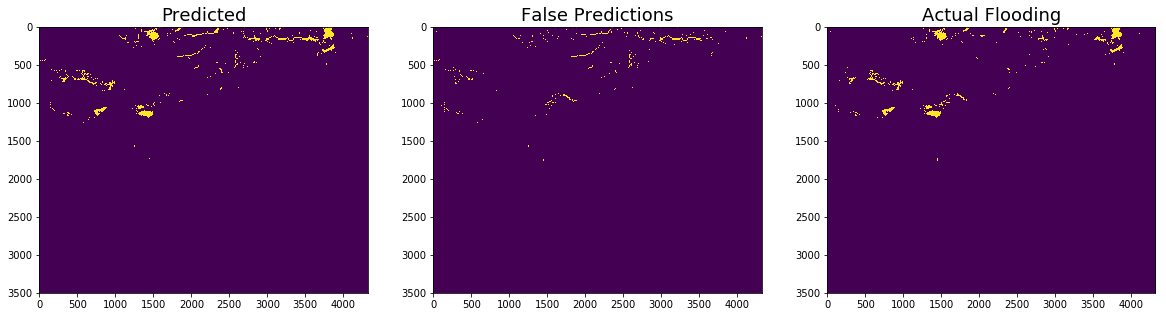

In [95]:
#================== Plotting results

# Reshape predicted values into array
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape
        arr_empty = np.zeros(shape)

y_pred_arr = arr_empty
rows, cols = zip(arr_ind)
y_pred_arr[rows, cols] = y_pred_img

# Reshape incorrect values into array
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(2).shape
        incorrect = np.empty(shape=(len(y_pred_img), ))
        arr_empty = np.zeros(shape)

for actual, predicted, i in zip(Y, y_pred_img, range(len(incorrect))):
    if predicted != actual:
        incorrect[i] = 1
    else:
        incorrect[i] = 0

incorrect_arr = arr_empty
incorrect_arr[rows, cols] = incorrect

# Plot actual flooding
arr_empty = np.zeros(shape)
y_true = arr_empty
rows, cols = zip(arr_ind)
y_true[rows, cols] = Y
        

plt.figure(figsize=(20,13))
columns = 3
images = [y_pred_arr, incorrect_arr, y_true]
titles = ['Predicted', 'False Predictions', 'Actual Flooding']
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.title(titles[i], fontdict = {'fontsize' : 18})
    plt.imshow(image)
    plt.colorbar

### Testing SVMs with different kernels

In [114]:
from sklearn.svm import SVC
import scipy.stats as stats
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

In [118]:
kernel = 'rbf'

# Benchmark gridsearch time
start_time = time.time()

# Grid of values for tuning hyperparameters
# C Low C maximizes the minimum margin of the hyperplane, large C tries to maximize correct separation of instances
# Gamma defines how far the reach of a single training instance reaches. Low gamma = far reach, high gamma = close reach

# grid = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
#          'tol': [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]}]

# model = SVC(kernel=kernel)

# gridcv = GridSearchCV(estimator=model, param_grid=grid, return_train_score=True)
# gridcv.fit(X_train, y_train)

# Creatin
rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(model, param_distributions = rand_list, n_iter = 20, 
                                 n_jobs = 4, cv = 3, random_state = 2017, scoring = 'accuracy') 
rand_search.fit(X_train, y_train) 
rand_search.cv_results_

print('Randomized search runtime: ' + str(timer(start_time, time.time())))

00:27:41.60
Randomized search runtime: None


In [125]:
# Benchmark training time
start_time = time.time()

clf = SVC(C = rand_search.best_estimator_.C,
          kernel=kernel,
          gamma=rand_search.best_estimator_.gamma,
          random_state=0)

# Training using sample points
clf.fit(X_train, y_train)

print('SVM rbf training runtime: ' + str(timer(start_time, time.time())))

y_pred = clf.predict(X_test)

print('SVM rbf prediction runtime: ' + str(timer(start_time, time.time())))

00:02:46.68
SVM rbf training runtime: None
00:03:03.52
SVM rbf prediction runtime: None


### Polynomial kernel

In [127]:
# Performance metrics
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(y_test, y_pred)/len(y_pred)*100, labels=['flooded','notFlooded'])

# Top row = predicted, left col = true

import math
def compute_rmse(predictions, yvalues):
    rmse = math.sqrt((sum((predictions - yvalues)**2))/len(yvalues))
    return rmse


Classification report for classifier SVC(C=2.209602254061174, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.8670701646824878,
  kernel='rbf', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.72      0.99      0.83      4391
          1       0.99      0.65      0.78      4876

avg / total       0.86      0.81      0.81      9267


                  flooded notFlooded 
       flooded       47.0        0.4 
    notFlooded       18.5       34.2 


### Polynomial kernel SVM

In [128]:
kernel = 'poly'

# Benchmark gridsearch time
start_time = time.time()

# Grid of values for tuning hyperparameters
# C Low C maximizes the minimum margin of the hyperplane, large C tries to maximize correct separation of instances
# Gamma defines how far the reach of a single training instance reaches. Low gamma = far reach, high gamma = close reach

# grid = [{'C': [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6],
#          'tol': [10**-4, 10**-3, 10**-2, 10**-1, 10, 10**1, 10**2, 10**3, 10**4, 10**5, 10**6]}]

# model = SVC(kernel=kernel)

# gridcv = GridSearchCV(estimator=model, param_grid=grid, return_train_score=True)
# gridcv.fit(X_train, y_train)

# Creatin
rand_list = {"C": stats.uniform(2, 10),
             "gamma": stats.uniform(0.1, 1)}
              
rand_search = RandomizedSearchCV(model, param_distributions = rand_list, n_iter = 20, 
                                 n_jobs = 4, cv = 3, random_state = 2017, scoring = 'accuracy') 
rand_search.fit(X_train, y_train) 
rand_search.cv_results_

print('Randomized search runtime: ' + str(timer(start_time, time.time())))

00:23:52.96
Randomized search runtime: None


In [129]:
# Benchmark training time
start_time = time.time()

clf = SVC(C = rand_search.best_estimator_.C,
          kernel=kernel,
          gamma=rand_search.best_estimator_.gamma,
          random_state=0)

# Training using sample points
clf.fit(X_train, y_train)

print('SVM rbf training runtime: ' + str(timer(start_time, time.time())))

y_pred = clf.predict(X_test)

print('SVM rbf prediction runtime: ' + str(timer(start_time, time.time())))

00:00:04.92
SVM rbf training runtime: None
00:00:05.92
SVM rbf prediction runtime: None


In [130]:
# Performance metrics
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(y_test, y_pred)/len(y_pred)*100, labels=['flooded','notFlooded'])

# Top row = predicted, left col = true

import math
def compute_rmse(predictions, yvalues):
    rmse = math.sqrt((sum((predictions - yvalues)**2))/len(yvalues))
    return rmse


Classification report for classifier SVC(C=2.209602254061174, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.8670701646824878,
  kernel='poly', max_iter=-1, probability=False, random_state=0,
  shrinking=True, tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.00      0.00      0.00      4391
          1       0.53      1.00      0.69      4876

avg / total       0.28      0.53      0.36      9267


                  flooded notFlooded 
       flooded        0.0       47.4 
    notFlooded        0.0       52.6 


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Predict on cloud section

In [ ]:
# Attempt #2 to predict:
# No sparse matrix. Instead get indices of matrix cells with values from cloudy image. Then remove NoData values, predict
# on that dense matrix, then recreate the matrix using indices and plot

import matplotlib.pyplot as plt

feat_list_train = list(df.columns)

# Path to folder with tifs
path = '../data/images/clouds_4337_LC08_026038_20160325'
arr = rasterToArray(path)

# Convert NoData to None
arr[np.where(arr == -999999)] = None

 # Get indices of values. These are the indices of the original image array
with rasterio.open(path + '/stack/stack.tif', 'r') as ds:
        arr_ind = np.where(ds.read(2) != -999999)

arr_clean = arr[~np.isnan(arr).any(axis=1)] # Remove NoData values

# Split into features and target
X = np.delete(arr_clean, feat_list_train.index('flooded'), 1) 
Y = arr_clean[:,feat_list_train.index('flooded')]

# Predict
y_pred_img = clf.predict(X)

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(Y, y_pred_img)))

# Confusion matrix
print_cm(metrics.confusion_matrix(Y, y_pred_img)/len(y_pred_img)*100, labels=['notFlooded','Flooded'])
# Top row = predicted, left col = true

## Random Forest classifier

In [133]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Tune hyperparameters
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# pprint(random_grid)

# Instantiate RF model
rf = RandomForestRegressor()

start_time = time.time()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

print('Randomized search runtime: ' + str(timer(start_time, time.time())))

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.3min finished


00:42:47.42
Randomized search runtime: None


{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': False}

In [138]:
start_time = time.time()

# Instantiate model with best parameters from random search
clf = RandomForestClassifier(n_estimators = rf_random.best_estimator_.n_estimators, 
                             max_depth = rf_random.best_estimator_.max_depth,
                             max_features = rf_random.best_estimator_.max_features,
                             min_samples_split = rf_random.best_estimator_.min_samples_split,
                             min_samples_leaf = rf_random.best_estimator_.min_samples_leaf,
                             bootstrap = rf_random.best_estimator_.bootstrap,
                             random_state=0)

# Fit the RF model to data
clf.fit(X_train, y_train)

print('SVM rbf training runtime: ' + str(timer(start_time, time.time())))

start_time = time.time()

# Predict on test data
y_pred = clf.predict(X_test)

print('SVM rbf prediction runtime: ' + str(timer(start_time, time.time())))

00:00:31.00
SVM rbf training runtime: None
00:00:02.39
SVM rbf prediction runtime: None


In [139]:
# Performance metrics
from sklearn import metrics

print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(y_test, y_pred)))

# Confusion matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.1f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

print_cm(metrics.confusion_matrix(y_test, y_pred)/len(y_pred)*100, labels=['flooded','notFlooded'])

# Top row = predicted, left col = true

import math
def compute_rmse(predictions, yvalues):
    rmse = math.sqrt((sum((predictions - yvalues)**2))/len(yvalues))
    return rmse


Classification report for classifier RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False):
             precision    recall  f1-score   support

          0       0.85      0.92      0.88      4391
          1       0.92      0.86      0.89      4876

avg / total       0.89      0.89      0.89      9267


                  flooded notFlooded 
       flooded       43.5        3.9 
    notFlooded        7.5       45.1 
